## Recommend Books to Users: A demo of how Object2Vec works

### About the Dataset

We will look at book ratings dataset from book crossing community. The dataset consists of ratings from over 100k book lovers.  More details on this dataset can be found at its [`Book-Crossing Dataset`](http://www2.informatik.uni-freiburg.de/~cziegler/BX/).

### License

Improving Recommendation Lists Through Topic Diversification,
Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; Proceedings of the 14th International World Wide Web Conference (WWW '05), May 10-14, 2005, Chiba, Japan. To appear.

In [1]:
#Install relevant python packages
!pip install --upgrade pip
!pip install jsonlines
!pip install pyarrow

    100% |████████████████████████████████| 1.4MB 21.4MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
    100% |████████████████████████████████| 12.5MB 4.2MB/s eta 0:00:01


In [2]:
#Import relevant modules 
import os
import io
import string
import sys
import csv, jsonlines
import numpy as np
import pandas as pd
import copy
import random
import boto3
from sagemaker.session import s3_input
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import s3fs
import pyarrow.parquet as pq

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

### Read the dataset from s3

In [4]:
#Read the prepared dataset from s3 bucket

s3 = s3fs.S3FileSystem()

s3_bucket = 's3://ai-in-aws/'
input_prefix = 'object2vec/bookratings/bookratings.parquet'
dataset_name = s3_bucket + input_prefix

df_bkRatngs = pq.ParquetDataset(dataset_name, filesystem=s3).read_pandas().to_pandas()

In [5]:
df_bkRatngs['BookRating'] = pd.to_numeric(df_bkRatngs['BookRating'])

##### Remove outliers in the dataset

In [6]:
#Inspect the book ratings dataset
#Remove zero ratings from the dataset since there is a large number of them

df_bkRatngs = df_bkRatngs[df_bkRatngs.BookRating > 0]

df_bkRatngs.head()
len(df_bkRatngs)

169555

In [7]:
# Number of unique users
# Number of unique books
#10467 (users), 32,977 (books)

num_users = len(df_bkRatngs['user_ind'].unique())
num_books = len(df_bkRatngs['book_ind'].unique())

print('Number of unique users: ', num_users)
print('Number of unique books: ', num_books)

Number of unique users:  9648
Number of unique books:  30036


In [8]:
df_bkRatngs.head()

,ISBN,UserID,BookRating,BookTitle,book_ind,user_ind
6,0060160772,275922,10,"Peace, Love and Healing: Bodymind Communicatio...",280,7146
7,0060160772,128835,10,"Peace, Love and Healing: Bodymind Communicatio...",280,1121
9,0060176059,142524,8,Tales of Burning Love,342,1698
11,0060176059,265205,5,Tales of Burning Love,342,6705
14,0060176059,107324,7,Tales of Burning Love,342,287


In [9]:
#Reset user and book indexes

uniq_users = pd.DataFrame(data=df_bkRatngs['UserID'].unique(), columns=['UserID'])
uniq_users['user_ind'] = np.arange(num_users)

uniq_books = pd.DataFrame(data=df_bkRatngs['ISBN'].unique(), columns=['ISBN'])
uniq_books['book_ind'] = np.arange(num_books)



In [76]:
max(uniq_users['user_ind'])

9647

In [10]:
max(uniq_books['book_ind'] )

30035

In [11]:
#Create final ratings dataset

#pd.merge(restaurant_ids_dataframe, restaurant_review_frame, on='business_id', how='outer')

df_bkRatngs = df_bkRatngs.drop(columns = ['user_ind', 'book_ind'])

df_bkRatngs = pd.merge(df_bkRatngs, uniq_users, on='UserID', how='inner').merge(uniq_books, on='ISBN', how='inner')

In [12]:
df_bkRatngs.head()

,ISBN,UserID,BookRating,BookTitle,user_ind,book_ind
0,0060160772,275922,10,"Peace, Love and Healing: Bodymind Communicatio...",0,0
1,0060160772,128835,10,"Peace, Love and Healing: Bodymind Communicatio...",1,0
2,0446519138,275922,10,Simple Abundance: A Daybook of Comfort and Joy,0,2576
3,0446519138,267326,9,Simple Abundance: A Daybook of Comfort and Joy,6,2576
4,0446519138,16795,8,Simple Abundance: A Daybook of Comfort and Joy,11,2576


In [13]:
#Save the clean dataframe 
df_bkRatngs.to_csv('ClndBookRatings.csv', header='true', index=False)

### Utility Functions

In [123]:
run UtilityFunctions.py

In [124]:
#Load the data as json lines (the format in which object2vec requires input)

data_list, ratings_list = load_df_data(df_bkRatngs)

There are 169555 ratings
The ratings have mean: 7.75, median: 8.0, and variance: 3.23
There are 9648 unique users and 30036 unique books


#### Look at Ratings distribution

Text(0.5,1,'User Ratings')

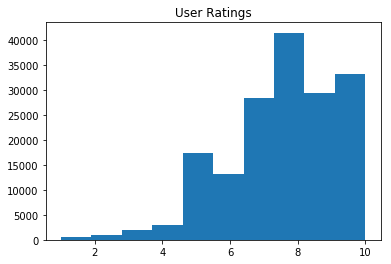

In [18]:
# Distribution of rating

f = plt.figure(1)
plt.hist(ratings_list)
plt.title("User Ratings")

### Create Training, Validation and Test data sets

In [19]:
#data_list, ratings_list = load_df_data(df_bkRatngs)
random.shuffle(data_list)

n_train = int(0.8 * len(data_list))

# split train and test
train_list = data_list[:n_train] 
test_list = data_list[n_train:]

print(len(train_list))
print(len(test_list))

# further split test set into validation set and test set
n_test = len(test_list)
val_list = test_list[:n_test//2]
test_list = test_list[n_test//2:]

random.shuffle(train_list)
random.shuffle(val_list)


print(train_list[:5])

135644
33911
[{'in0': [251], 'in1': [23829], 'label': 8.0}, {'in0': [5074], 'in1': [25701], 'label': 10.0}, {'in0': [5993], 'in1': [4720], 'label': 1.0}, {'in0': [1906], 'in1': [1074], 'label': 9.0}, {'in0': [110], 'in1': [11014], 'label': 10.0}]


#### Write the data  in the format required by Object2Vec

The object2vec algorithm is used predict exact ratings of a book by a given user.
We provide the algorithm userID, itemID pairs. For each such pair, we also provide "label" that tells the algorithm whether user and item are similar or not

In [117]:
write_data_list_to_jsonl(copy.deepcopy(train_list), 'train_r.jsonl')
write_data_list_to_jsonl(copy.deepcopy(val_list), 'validation_r.jsonl')

Created train_r.jsonl jsonline file
Created validation_r.jsonl jsonline file


### Model Training

Define S3 bucket that hosts the data and model, and upload data to the relevant bucket. Define the paths (on s3) containing training and validation data

In [118]:
bucket = 'ai-in-aws' #Designate your own bucket name
input_prefix = 'object2vec/bookratings/input'
output_prefix = 'object2vec/bookratings/output'

In [119]:
s3_client = boto3.client('s3')
input_paths = {} #initialize dictionary
output_path = os.path.join('s3://', bucket, output_prefix)


for data_name in ['train', 'validation']:
    pre_key = os.path.join(input_prefix, 'rating', f'{data_name}') #F-string: embed python expression inside string literal
    fname = '{}_r.jsonl'.format(data_name)
    data_path = os.path.join('s3://', bucket, pre_key, fname)
    #upload data to S3
    s3_client.upload_file(fname, bucket, os.path.join(pre_key, fname))
    
    #Create definition of input data; data_path - path containing s3 data
    input_paths[data_name] = s3_input(data_path, distribution='ShardedByS3Key', content_type='application/jsonlines')
    print('Uploaded {} data to {} and defined input path'.format(data_name, data_path))
    
print('Trained model will be saved at', output_path)    

Uploaded train data to s3://ai-in-aws/object2vec/bookratings/input/rating/train/train_r.jsonl and defined input path
Uploaded validation data to s3://ai-in-aws/object2vec/bookratings/input/rating/validation/validation_r.jsonl and defined input path
Trained model will be saved at s3://ai-in-aws/object2vec/bookratings/output


##### Get image of ObjectToVec Algorithm

In [151]:
sess = sagemaker.Session()
role = get_execution_role()

#Get docker image for the ObjectToVec algorithm
container = get_image_uri(boto3.Session().region_name, 'object2vec') #input: region name, name of the algorithm

##### Let's define hyperparameters

In [156]:
static_hyperparameters = { 
    "_kvstore": "device", #type of GPU
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    #"dropout": 0.3,
    "bucket_width": 0,
    "early_stopping_patience": 2,
    "early_stopping_tolerance": 0.01,
    #"enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
   #"enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 9648, #number of unique users
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    #"enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 30036,  #number of unique books
    "enc_dim": 1024, 
    "epochs": 10,
    #"learning_rate": 0.01,
    "mini_batch_size": 64,
    "mlp_activation": "relu",
    "mlp_dim": 256,
    "mlp_layers": 1,
   # "num_classes": 2, #( 0 or 1)
    "optimizer": "adam",
    #"weight_decay": 1000,
    "output_layer": "mean_squared_error"
}

In [157]:
## get estimator
regressor = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.p2.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## set hyperparameters
regressor.set_hyperparameters(**static_hyperparameters)

## train, tune, and test the model
regressor.fit(input_paths)

INFO:sagemaker:Creating training-job with name: object2vec-2019-02-03-22-14-21-943


2019-02-03 22:14:22 Starting - Starting the training job...
2019-02-03 22:14:23 Starting - Launching requested ML instances......
2019-02-03 22:15:26 Starting - Preparing the instances for training......
2019-02-03 22:16:43 Downloading - Downloading input data
2019-02-03 22:16:43 Training - Downloading the training image......
2019-02-03 22:17:39 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[02/03/2019 22:17:42 INFO 139717476005696] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 20, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'enc0_token_embedding_dim': 300, u'enc1_network': u'enc0', u'learning_rate': 0.0004, u'enc1_cnn_filter_width': 3, u'

[02/03/2019 22:17:50 INFO 139717476005696] arg_params keys for module initialization: []
[02/03/2019 22:17:50 INFO 139717476005696] all params:['output_layer_weight', 'mlp_fc0_weight', 'mlp_fc0_bias', 'output_layer_bias', 'embed_1_weight', 'embed_0_weight']
#metrics {"Metrics": {"initialize.time": {"count": 1, "max": 4171.811103820801, "sum": 4171.811103820801, "min": 4171.811103820801}}, "EndTime": 1549232270.855384, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "ObjectToVec"}, "StartTime": 1549232262.23444}

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max

[02/03/2019 22:18:40 INFO 139717476005696] Epoch: 1, batches: 200, num_examples: 12800, 2699.6 samples/sec, epoch time so far: 0:00:04.741470
[02/03/2019 22:18:40 INFO 139717476005696] #011Training metrics: mean_squared_error: 1.600 mean_absolute_error: 0.971 
[02/03/2019 22:18:43 INFO 139717476005696] Epoch: 1, batches: 300, num_examples: 19200, 2801.3 samples/sec, epoch time so far: 0:00:06.853990
[02/03/2019 22:18:43 INFO 139717476005696] #011Training metrics: mean_squared_error: 1.549 mean_absolute_error: 0.954 
[02/03/2019 22:18:45 INFO 139717476005696] Epoch: 1, batches: 400, num_examples: 25600, 2863.5 samples/sec, epoch time so far: 0:00:08.940046
[02/03/2019 22:18:45 INFO 139717476005696] #011Training metrics: mean_squared_error: 1.517 mean_absolute_error: 0.944 
[02/03/2019 22:18:47 INFO 139717476005696] Epoch: 1, batches: 500, num_examples: 32000, 2902.4 samples/sec, epoch time so far: 0:00:11.025538
[02/03/2019 22:18:47 INFO 139717476005696] #011Training metrics: mean_squar

[02/03/2019 22:19:32 INFO 139717476005696] Epoch: 2, batches: 500, num_examples: 32000, 2938.2 samples/sec, epoch time so far: 0:00:10.890971
[02/03/2019 22:19:32 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.784 mean_absolute_error: 0.665 
[02/03/2019 22:19:34 INFO 139717476005696] Epoch: 2, batches: 600, num_examples: 38400, 2958.9 samples/sec, epoch time so far: 0:00:12.977578
[02/03/2019 22:19:34 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.779 mean_absolute_error: 0.663 
[02/03/2019 22:19:36 INFO 139717476005696] Epoch: 2, batches: 700, num_examples: 44800, 2973.8 samples/sec, epoch time so far: 0:00:15.065024
[02/03/2019 22:19:36 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.778 mean_absolute_error: 0.662 
[02/03/2019 22:19:38 INFO 139717476005696] Epoch: 2, batches: 800, num_examples: 51200, 2984.6 samples/sec, epoch time so far: 0:00:17.154645
[02/03/2019 22:19:38 INFO 139717476005696] #011Training metrics: mean_squar

[02/03/2019 22:20:25 INFO 139717476005696] Epoch: 3, batches: 900, num_examples: 57600, 2991.1 samples/sec, epoch time so far: 0:00:19.256885
[02/03/2019 22:20:25 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.619 mean_absolute_error: 0.614 
[02/03/2019 22:20:27 INFO 139717476005696] Epoch: 3, batches: 1000, num_examples: 64000, 2997.2 samples/sec, epoch time so far: 0:00:21.353079
[02/03/2019 22:20:27 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.615 mean_absolute_error: 0.612 
[02/03/2019 22:20:29 INFO 139717476005696] Epoch: 3, batches: 1100, num_examples: 70400, 3002.9 samples/sec, epoch time so far: 0:00:23.443753
[02/03/2019 22:20:29 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.611 mean_absolute_error: 0.610 
[02/03/2019 22:20:32 INFO 139717476005696] Epoch: 3, batches: 1200, num_examples: 76800, 3008.2 samples/sec, epoch time so far: 0:00:25.530554
[02/03/2019 22:20:32 INFO 139717476005696] #011Training metrics: mean_sq

[02/03/2019 22:21:17 INFO 139717476005696] Epoch: 4, batches: 1200, num_examples: 76800, 3007.4 samples/sec, epoch time so far: 0:00:25.537141
[02/03/2019 22:21:17 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.379 mean_absolute_error: 0.473 
[02/03/2019 22:21:19 INFO 139717476005696] Epoch: 4, batches: 1300, num_examples: 83200, 3011.1 samples/sec, epoch time so far: 0:00:27.630656
[02/03/2019 22:21:19 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.378 mean_absolute_error: 0.473 
[02/03/2019 22:21:21 INFO 139717476005696] Epoch: 4, batches: 1400, num_examples: 89600, 3014.7 samples/sec, epoch time so far: 0:00:29.720814
[02/03/2019 22:21:21 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.377 mean_absolute_error: 0.472 
[02/03/2019 22:21:23 INFO 139717476005696] Epoch: 4, batches: 1500, num_examples: 96000, 3018.0 samples/sec, epoch time so far: 0:00:31.809308
[02/03/2019 22:21:23 INFO 139717476005696] #011Training metrics: mean_s

[02/03/2019 22:22:08 INFO 139717476005696] Epoch: 5, batches: 1500, num_examples: 96000, 3063.5 samples/sec, epoch time so far: 0:00:31.337045
[02/03/2019 22:22:08 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.308 mean_absolute_error: 0.430 
[02/03/2019 22:22:10 INFO 139717476005696] Epoch: 5, batches: 1600, num_examples: 102400, 3063.9 samples/sec, epoch time so far: 0:00:33.421789
[02/03/2019 22:22:10 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.307 mean_absolute_error: 0.429 
[02/03/2019 22:22:12 INFO 139717476005696] Epoch: 5, batches: 1700, num_examples: 108800, 3063.8 samples/sec, epoch time so far: 0:00:35.510926
[02/03/2019 22:22:12 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.306 mean_absolute_error: 0.429 
[02/03/2019 22:22:14 INFO 139717476005696] Epoch: 5, batches: 1800, num_examples: 115200, 3063.9 samples/sec, epoch time so far: 0:00:37.598848
[02/03/2019 22:22:14 INFO 139717476005696] #011Training metrics: mea

[02/03/2019 22:22:55 INFO 139717476005696] Epoch: 6, batches: 1600, num_examples: 102400, 3020.9 samples/sec, epoch time so far: 0:00:33.896773
[02/03/2019 22:22:55 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.271 mean_absolute_error: 0.405 
[02/03/2019 22:22:57 INFO 139717476005696] Epoch: 6, batches: 1700, num_examples: 108800, 3023.7 samples/sec, epoch time so far: 0:00:35.982376
[02/03/2019 22:22:57 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.270 mean_absolute_error: 0.404 
[02/03/2019 22:22:59 INFO 139717476005696] Epoch: 6, batches: 1800, num_examples: 115200, 3026.2 samples/sec, epoch time so far: 0:00:38.067559
[02/03/2019 22:22:59 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.270 mean_absolute_error: 0.404 
[02/03/2019 22:23:01 INFO 139717476005696] Epoch: 6, batches: 1900, num_examples: 121600, 3028.3 samples/sec, epoch time so far: 0:00:40.154800
[02/03/2019 22:23:01 INFO 139717476005696] #011Training metrics: me

[02/03/2019 22:23:48 INFO 139717476005696] Epoch: 7, batches: 2000, num_examples: 128000, 3029.5 samples/sec, epoch time so far: 0:00:42.251657
[02/03/2019 22:23:48 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.256 mean_absolute_error: 0.393 
[02/03/2019 22:23:50 INFO 139717476005696] Epoch: 7, batches: 2100, num_examples: 134400, 3031.1 samples/sec, epoch time so far: 0:00:44.340736
[02/03/2019 22:23:50 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.255 mean_absolute_error: 0.393 
[02/03/2019 22:23:51 INFO 139717476005696] **************
[02/03/2019 22:23:51 INFO 139717476005696] Completed Epoch: 7, time taken: 0:00:44.758909
[02/03/2019 22:23:51 INFO 139717476005696] Epoch 7 Training metrics:   mean_squared_error: 0.255 mean_absolute_error: 0.393 
[02/03/2019 22:23:51 INFO 139717476005696] #quality_metric: host=algo-1, epoch=7, train mean_squared_error <loss>=0.254967804907
[02/03/2019 22:23:51 INFO 139717476005696] Epoch 7 Validation metrics: m

[02/03/2019 22:24:39 INFO 139717476005696] Epoch: 9, batches: 100, num_examples: 6400, 2512.5 samples/sec, epoch time so far: 0:00:02.547295
[02/03/2019 22:24:39 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.236 mean_absolute_error: 0.382 
[02/03/2019 22:24:41 INFO 139717476005696] Epoch: 9, batches: 200, num_examples: 12800, 2759.4 samples/sec, epoch time so far: 0:00:04.638713
[02/03/2019 22:24:41 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.213 mean_absolute_error: 0.361 
[02/03/2019 22:24:43 INFO 139717476005696] Epoch: 9, batches: 300, num_examples: 19200, 2855.0 samples/sec, epoch time so far: 0:00:06.724962
[02/03/2019 22:24:43 INFO 139717476005696] #011Training metrics: mean_squared_error: 0.202 mean_absolute_error: 0.351 
[02/03/2019 22:24:45 INFO 139717476005696] Epoch: 9, batches: 400, num_examples: 25600, 2905.0 samples/sec, epoch time so far: 0:00:08.812466
[02/03/2019 22:24:45 INFO 139717476005696] #011Training metrics: mean_square


2019-02-03 22:25:51 Completed - Training job completed
Billable seconds: 556


### Model Deployment

In [158]:
from sagemaker.predictor import json_serializer, json_deserializer

# create a model using the trained algorithm
regression_model = regressor.create_model(
                        serializer=json_serializer,
                        deserializer=json_deserializer,
                        content_type='application/json')

In [159]:
# deploy the model
predictor = regression_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: object2vec-2019-02-03-22-28-12-576
INFO:sagemaker:Creating endpoint with name object2vec-2019-02-03-22-28-12-576


---------------------------------------------------------------------------!

### Model Evaluation

#### Convert test data in the format required by object2vec

In [84]:
test_data, test_label = data_list_to_inference_format(copy.deepcopy(test_list), binarize=False)

data_ : [({'in0': [1381], 'in1': [13097]}, 8.0), ({'in0': [1272], 'in1': [17893]}, 8.0), ({'in0': [2533], 'in1': [22169]}, 9.0), ({'in0': [335], 'in1': [11229]}, 5.0), ({'in0': [604], 'in1': [28176]}, 7.0), ({'in0': [1950], 'in1': [17609]}, 9.0), ({'in0': [1560], 'in1': [7011]}, 6.0), ({'in0': [2498], 'in1': [10821]}, 8.0), ({'in0': [389], 'in1': [4860]}, 10.0), ({'in0': [661], 'in1': [9227]}, 5.0), ({'in0': [944], 'in1': [21295]}, 3.0), ({'in0': [2224], 'in1': [3506]}, 10.0), ({'in0': [1507], 'in1': [12154]}, 8.0), ({'in0': [1948], 'in1': [588]}, 8.0), ({'in0': [1306], 'in1': [14039]}, 8.0), ({'in0': [6965], 'in1': [13341]}, 9.0), ({'in0': [8966], 'in1': [23773]}, 10.0), ({'in0': [2155], 'in1': [19880]}, 7.0), ({'in0': [4806], 'in1': [9110]}, 8.0), ({'in0': [152], 'in1': [2399]}, 9.0), ({'in0': [3382], 'in1': [29304]}, 8.0), ({'in0': [57], 'in1': [1942]}, 10.0), ({'in0': [5380], 'in1': [10532]}, 10.0), ({'in0': [4304], 'in1': [5639]}, 7.0), ({'in0': [2476], 'in1': [26967]}, 7.0), ({'i

In [160]:
# Send data to the endpoint to get predictions
prediction = predictor.predict(test_data)

print("The mean squared error on test set is %.3f" %get_mse_loss(prediction, test_label))

The mean squared error on test set is 2.390


MSE of 2.39 is better than the baselines: 
Option 1 MSE: 3.15, where predicted book rating is global average book rating across all users
Option 2 MSE: 2.57, where predicted book rating is average book rating by user

#### Baseline  1

Compute average book rating on training dataset and use it as your prediction for books in test dataset

In [113]:
#Option 1
train_label = [row['label'] for row in copy.deepcopy(train_list)]

bs1_prediction = round(np.mean(train_label), 2)
print("The validation mse loss of the Baseline 1 is {}".format(
                                     get_mse_loss(len(test_label)*[bs1_prediction], test_label)))

The validation mse loss of the Baseline 1 is 3.15


In [81]:
#Create user dictionary for users in training dataset
to_users_dict, to_books_dict = jsnl_to_augmented_data_dict(train_list)

In [59]:
#Inspect users dict
to_users_dict

{798: [(7555, 9.0),
  (23166, 8.0),
  (28279, 5.0),
  (14115, 8.0),
  (6695, 8.0),
  (17665, 9.0),
  (3946, 7.0),
  (21806, 8.0),
  (22278, 9.0),
  (19131, 8.0),
  (10368, 8.0),
  (198, 9.0),
  (4950, 9.0),
  (29071, 8.0),
  (27834, 7.0),
  (23461, 8.0),
  (13597, 10.0),
  (26427, 8.0),
  (5400, 10.0),
  (13113, 10.0),
  (10393, 10.0),
  (16708, 8.0),
  (21027, 8.0),
  (9036, 6.0),
  (8710, 9.0),
  (8730, 5.0),
  (9888, 8.0),
  (23154, 5.0),
  (12637, 9.0),
  (13475, 6.0),
  (9626, 6.0),
  (4994, 9.0),
  (15229, 9.0),
  (22751, 9.0),
  (13177, 9.0),
  (29302, 9.0),
  (19642, 5.0),
  (2813, 8.0),
  (21372, 9.0),
  (5333, 8.0),
  (972, 10.0),
  (1075, 6.0),
  (23822, 8.0),
  (12099, 10.0),
  (11760, 9.0),
  (15637, 8.0),
  (25098, 8.0),
  (176, 8.0),
  (15991, 10.0),
  (5935, 7.0),
  (10255, 9.0),
  (16591, 9.0),
  (7823, 9.0),
  (7029, 9.0),
  (26007, 9.0),
  (9300, 10.0),
  (18991, 10.0),
  (5418, 10.0),
  (23976, 6.0),
  (4004, 9.0),
  (3701, 7.0),
  (20049, 10.0),
  (22897, 6.0),
  (

#### Baseline  2

Instead of global average book rating, let's use average book rating by user. To illustrate, for a given user, we will take average book rating across all the books he rated. We will use this rating as our prediction, and compare it to the label (actual value). 

In [ ]:
#Determine how many test users are in training dataset
#We can only compute average book rating by user, only if the user is in training dataset

dftest = pd.DataFrame()
dftrain = pd.DataFrame()

#test
tusrlist = [] 
for row in test_list:
    tusrlist.append(row['in0'][0])

#train
tr_usrlist = []

for row in train_list:
    tr_usrlist.append(row['in0'][0])
    
dftest = pd.DataFrame({'userID':tusrlist})
dftrain = pd.DataFrame({'userID':tr_usrlist})

dfmatch = dftest[dftest['userID'].isin(dftrain['userID'])]

len(dftest['userID'].unique())
#5,631 users are in test dataset

len(dftrain['userID'].unique())
#9,489 users are in train dataset

len(dfmatch['userID'].unique())
# Out of 5,631 users in test dataset, 5,541 users only are in training set


In [114]:
#Option 2:
def bs2_predictor(test_data, user_dict):
    test_data = copy.deepcopy(test_data['instances'])
    predictions = list()
    for row in test_data:
        userID = int(row["in0"][0])
        # predict book rating based on local average of user's prediction
        if userID in user_dict:
            local_books, local_ratings = zip(*user_dict[userID])
            local_ratings = [float(score) for score in local_ratings]
            predictions.append(np.mean(local_ratings))
        else:
            #For users not in training set, let's user global average rating
            predictions.append(bs1_prediction)
            #print ("predictions per user", predictions[-1])    
    return predictions

In [115]:
bs2_prediction = bs2_predictor(test_data, to_users_dict)

print("The validation loss of the Baseline 2 (user-based rating average) is {}".format(
                                     get_mse_loss(bs2_prediction, test_label)))

The validation loss of the Baseline 2 (user-based rating average) is 2.57


### Hyperparameter tuning to optimize model performance

In [127]:
from time import gmtime, strftime 
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

tuning_job_name = "object2vec-job-{}".format(strftime("%d-%H-%M-%S", gmtime()))

hyperparameters_ranges = { "learning_rate": ContinuousParameter(0.0004, 0.02),
                            "dropout": ContinuousParameter(0.0, 0.4),  
                            "enc_dim": IntegerParameter(1000, 2000),
                            "mlp_dim": IntegerParameter(256, 500),
                            "weight_decay": ContinuousParameter(0, 300) }     

objective_metric_name = 'validation:mean_squared_error'


regressor = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.p2.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## set hyperparameters
regressor.set_hyperparameters(**static_hyperparameters)

tuner = HyperparameterTuner(regressor, 
                            objective_metric_name, 
                            hyperparameters_ranges,
                            objective_type='Minimize', 
                            max_jobs=10, 
                            max_parallel_jobs=1)

In [128]:
tuner.fit({'train': input_paths['train'], 'validation': input_paths['validation']}, 
          job_name=tuning_job_name, include_cls_metadata=False)
tuner.wait()

INFO:sagemaker:Creating hyperparameter tuning job with name: object2vec-job-03-18-19-21


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [134]:
objTunerAnltcs = tuner.analytics()

In [132]:
#Review summary of all the jobs executed
objTunerAnltcs.training_job_summaries(force_refresh=False)

[{'TrainingJobName': 'object2vec-job-03-18-19-21-010-0a4f6531',
  'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:109099157774:training-job/object2vec-job-03-18-19-21-010-0a4f6531',
  'CreationTime': datetime.datetime(2019, 2, 3, 20, 11, 36, tzinfo=tzlocal()),
  'TrainingStartTime': datetime.datetime(2019, 2, 3, 20, 14, 6, tzinfo=tzlocal()),
  'TrainingEndTime': datetime.datetime(2019, 2, 3, 20, 24, 14, tzinfo=tzlocal()),
  'TrainingJobStatus': 'Completed',
  'TunedHyperParameters': {'dropout': '0.10518026973338186',
   'enc_dim': '2000',
   'learning_rate': '0.007471052045944925',
   'mlp_dim': '489',
   'weight_decay': '77.51258593822514'},
  'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mean_squared_error',
   'Value': 3.1846425533294678},
  'ObjectiveStatus': 'Succeeded'},
 {'TrainingJobName': 'object2vec-job-03-18-19-21-009-6be1cd71',
  'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:109099157774:training-job/object2vec-job-03-18-19-21-009-6be1cd71',
  'C

In [135]:
dfTuning = objTunerAnltcs.dataframe(force_refresh=False)

In [138]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

# Now plot it
p = figure(plot_width=500, plot_height=500, 
               x_axis_type = 'datetime')
p.circle(source=dfTuning, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

In [139]:
dfTuning

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,dropout,enc_dim,learning_rate,mlp_dim,weight_decay
0,3.184643,608.0,2019-02-03 20:24:14+00:00,object2vec-job-03-18-19-21-010-0a4f6531,Completed,2019-02-03 20:14:06+00:00,0.105180,2000.0,0.007471,489.0,77.512586
1,3.185750,402.0,2019-02-03 20:10:11+00:00,object2vec-job-03-18-19-21-009-6be1cd71,Completed,2019-02-03 20:03:29+00:00,0.390622,1121.0,0.015050,305.0,159.763563
2,3.184650,407.0,2019-02-03 20:00:17+00:00,object2vec-job-03-18-19-21-008-59d2ab63,Completed,2019-02-03 19:53:30+00:00,0.011626,1177.0,0.019037,468.0,261.643445
3,3.195758,723.0,2019-02-03 19:50:22+00:00,object2vec-job-03-18-19-21-007-7783d580,Completed,2019-02-03 19:38:19+00:00,0.316875,1164.0,0.001237,284.0,275.828260
4,3.186197,618.0,2019-02-03 19:35:17+00:00,object2vec-job-03-18-19-21-006-ccca4715,Completed,2019-02-03 19:24:59+00:00,0.302629,1757.0,0.012972,500.0,82.044446
5,3.185097,416.0,2019-02-03 19:21:53+00:00,object2vec-job-03-18-19-21-005-40851de2,Completed,2019-02-03 19:14:57+00:00,0.315768,1201.0,0.012770,341.0,116.508191
6,3.185628,373.0,2019-02-03 19:12:00+00:00,object2vec-job-03-18-19-21-004-52ed057a,Completed,2019-02-03 19:05:47+00:00,0.197433,1033.0,0.018909,292.0,171.464002
7,3.186846,476.0,2019-02-03 19:01:28+00:00,object2vec-job-03-18-19-21-003-72db6efe,Completed,2019-02-03 18:53:32+00:00,0.103463,1438.0,0.015728,387.0,300.000000
8,3.185663,875.0,2019-02-03 18:49:18+00:00,object2vec-job-03-18-19-21-002-f9ea778f,Completed,2019-02-03 18:34:43+00:00,0.230424,1977.0,0.004224,413.0,240.000379
9,3.185057,478.0,2019-02-03 18:30:23+00:00,object2vec-job-03-18-19-21-001-00c1be32,Completed,2019-02-03 18:22:25+00:00,0.259083,1182.0,0.013333,423.0,285.956922


In [149]:
# How does MSE vary with encoder dimension
hover = HoverTool(
        tooltips=[
            ("Encoder Dim", "@enc_dim"),
            ("MSE", "@FinalObjectiveValue"),
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
               x_axis_type = 'linear')
p.circle(source=dfTuning, x='enc_dim', y='FinalObjectiveValue')
show(p)

#1177

In [147]:
# How does MSE vary with mlp dimension
hover = HoverTool(
        tooltips=[
            ("MLP Dim", "@mlp_dim"),
            ("MSE", "@FinalObjectiveValue"),
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
               x_axis_type = 'linear')
p.circle(source=dfTuning, x='mlp_dim', y='FinalObjectiveValue')
show(p)

#489

In [144]:
# How does MSE vary with learning date

hover = HoverTool(
        tooltips=[
            ("Learning Rate", "@learning_rate"),
            ("MSE", "@FinalObjectiveValue"),
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
               x_axis_type = 'linear')
p.circle(source=dfTuning, x='learning_rate', y='FinalObjectiveValue')
show(p)

#.019

In [150]:
# How does MSE vary with weight decay

hover = HoverTool(
        tooltips=[
            ("Weight Decay", "@weight_decay"),
            ("MSE", "@FinalObjectiveValue"),
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
               x_axis_type = 'linear')
p.circle(source=dfTuning, x='weight_decay', y='FinalObjectiveValue')
show(p)

#77

### Let's train the model with new hyperparameters

In [152]:
new_static_hyperparameters = { 
    "_kvstore": "device", #type of GPU
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    #"dropout": 0.3,
    "bucket_width": 0,
    "early_stopping_patience": 2,
    "early_stopping_tolerance": 0.01,
    #"enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
   #"enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 9648, #number of unique users
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    #"enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 30036,  #number of unique books
    "enc_dim": 1177, 
    "epochs": 10,
    "learning_rate": 0.007,
    "mini_batch_size": 64,
    "mlp_activation": "relu",
    "mlp_dim": 400,
    "mlp_layers": 1,
   # "num_classes": 2, #( 0 or 1)
    "optimizer": "adam",
    #"weight_decay": 1000,
    "output_layer": "mean_squared_error"
}

In [153]:
## get estimator
new_regressor = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.p2.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## set hyperparameters
new_regressor.set_hyperparameters(**new_static_hyperparameters)

## train, tune, and test the model
new_regressor.fit(input_paths)

INFO:sagemaker:Creating training-job with name: object2vec-2019-02-03-21-49-43-394


2019-02-03 21:49:43 Starting - Starting the training job...
2019-02-03 21:49:46 Starting - Launching requested ML instances......
2019-02-03 21:50:51 Starting - Preparing the instances for training......
2019-02-03 21:52:14 Downloading - Downloading input data
2019-02-03 21:52:14 Training - Downloading the training image.....
Docker entrypoint called with argument(s): train
[02/03/2019 21:52:53 INFO 140684407277376] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 20, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'enc0_token_embedding_dim': 300, u'enc1_network': u'enc0', u'learning_rate': 0.0004, u'enc1_cnn_filter_width': 3, u'negative_sampling_rate': 0, u'enc0_network': u'hcnn', u'enc1_layers': u'auto', u'early_st


2019-02-03 21:52:50 Training - Training image download completed. Training in progress.[02/03/2019 21:53:02 INFO 140684407277376] arg_params keys for module initialization: []
[02/03/2019 21:53:02 INFO 140684407277376] all params:['output_layer_weight', 'mlp_fc0_weight', 'mlp_fc0_bias', 'output_layer_bias', 'embed_1_weight', 'embed_0_weight']
#metrics {"Metrics": {"initialize.time": {"count": 1, "max": 3645.2457904815674, "sum": 3645.2457904815674, "min": 3645.2457904815674}}, "EndTime": 1549230782.715035, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "ObjectToVec"}, "StartTime": 1549230773.864397}

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"coun

[02/03/2019 21:54:16 INFO 140684407277376] Epoch: 1, batches: 300, num_examples: 19200, 2012.5 samples/sec, epoch time so far: 0:00:09.540348
[02/03/2019 21:54:16 INFO 140684407277376] #011Training metrics: mean_squared_error: 1.836 mean_absolute_error: 1.041 
[02/03/2019 21:54:19 INFO 140684407277376] Epoch: 1, batches: 400, num_examples: 25600, 2048.2 samples/sec, epoch time so far: 0:00:12.498602
[02/03/2019 21:54:19 INFO 140684407277376] #011Training metrics: mean_squared_error: 1.826 mean_absolute_error: 1.038 
[02/03/2019 21:54:22 INFO 140684407277376] Epoch: 1, batches: 500, num_examples: 32000, 2069.9 samples/sec, epoch time so far: 0:00:15.459500
[02/03/2019 21:54:22 INFO 140684407277376] #011Training metrics: mean_squared_error: 1.812 mean_absolute_error: 1.032 
[02/03/2019 21:54:24 INFO 140684407277376] Epoch: 1, batches: 600, num_examples: 38400, 2085.1 samples/sec, epoch time so far: 0:00:18.416264
[02/03/2019 21:54:24 INFO 140684407277376] #011Training metrics: mean_squar

[02/03/2019 21:55:25 INFO 140684407277376] Epoch: 2, batches: 500, num_examples: 32000, 2093.4 samples/sec, epoch time so far: 0:00:15.286056
[02/03/2019 21:55:25 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.839 mean_absolute_error: 0.693 
[02/03/2019 21:55:28 INFO 140684407277376] Epoch: 2, batches: 600, num_examples: 38400, 2104.5 samples/sec, epoch time so far: 0:00:18.246637
[02/03/2019 21:55:28 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.830 mean_absolute_error: 0.690 
[02/03/2019 21:55:31 INFO 140684407277376] Epoch: 2, batches: 700, num_examples: 44800, 2113.0 samples/sec, epoch time so far: 0:00:21.202529
[02/03/2019 21:55:31 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.824 mean_absolute_error: 0.688 
[02/03/2019 21:55:34 INFO 140684407277376] Epoch: 2, batches: 800, num_examples: 51200, 2119.3 samples/sec, epoch time so far: 0:00:24.158927
[02/03/2019 21:55:34 INFO 140684407277376] #011Training metrics: mean_squar

[02/03/2019 21:56:26 INFO 140684407277376] Epoch: 3, batches: 400, num_examples: 25600, 2077.4 samples/sec, epoch time so far: 0:00:12.323104
[02/03/2019 21:56:26 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.621 mean_absolute_error: 0.596 
[02/03/2019 21:56:29 INFO 140684407277376] Epoch: 3, batches: 500, num_examples: 32000, 2093.5 samples/sec, epoch time so far: 0:00:15.285542
[02/03/2019 21:56:29 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.605 mean_absolute_error: 0.588 
[02/03/2019 21:56:32 INFO 140684407277376] Epoch: 3, batches: 600, num_examples: 38400, 2104.8 samples/sec, epoch time so far: 0:00:18.243581
[02/03/2019 21:56:32 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.592 mean_absolute_error: 0.582 
[02/03/2019 21:56:35 INFO 140684407277376] Epoch: 3, batches: 700, num_examples: 44800, 2112.9 samples/sec, epoch time so far: 0:00:21.202977
[02/03/2019 21:56:35 INFO 140684407277376] #011Training metrics: mean_squar

[02/03/2019 21:57:26 INFO 140684407277376] Epoch: 4, batches: 300, num_examples: 19200, 2166.9 samples/sec, epoch time so far: 0:00:08.860776
[02/03/2019 21:57:26 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.596 mean_absolute_error: 0.589 
[02/03/2019 21:57:29 INFO 140684407277376] Epoch: 4, batches: 400, num_examples: 25600, 2164.5 samples/sec, epoch time so far: 0:00:11.826981
[02/03/2019 21:57:29 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.571 mean_absolute_error: 0.577 
[02/03/2019 21:57:32 INFO 140684407277376] Epoch: 4, batches: 500, num_examples: 32000, 2164.9 samples/sec, epoch time so far: 0:00:14.781116
[02/03/2019 21:57:32 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.557 mean_absolute_error: 0.571 
[02/03/2019 21:57:35 INFO 140684407277376] Epoch: 4, batches: 600, num_examples: 38400, 2164.0 samples/sec, epoch time so far: 0:00:17.744591
[02/03/2019 21:57:35 INFO 140684407277376] #011Training metrics: mean_squar

[02/03/2019 21:58:27 INFO 140684407277376] Epoch: 5, batches: 200, num_examples: 12800, 1995.9 samples/sec, epoch time so far: 0:00:06.413037
[02/03/2019 21:58:27 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.635 mean_absolute_error: 0.608 
[02/03/2019 21:58:30 INFO 140684407277376] Epoch: 5, batches: 300, num_examples: 19200, 2047.7 samples/sec, epoch time so far: 0:00:09.376420
[02/03/2019 21:58:30 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.581 mean_absolute_error: 0.581 
[02/03/2019 21:58:33 INFO 140684407277376] Epoch: 5, batches: 400, num_examples: 25600, 2075.2 samples/sec, epoch time so far: 0:00:12.336054
[02/03/2019 21:58:33 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.552 mean_absolute_error: 0.565 
[02/03/2019 21:58:36 INFO 140684407277376] Epoch: 5, batches: 500, num_examples: 32000, 2091.3 samples/sec, epoch time so far: 0:00:15.301613
[02/03/2019 21:58:36 INFO 140684407277376] #011Training metrics: mean_squar

[02/03/2019 21:59:27 INFO 140684407277376] Epoch: 6, batches: 100, num_examples: 6400, 2178.3 samples/sec, epoch time so far: 0:00:02.938041
[02/03/2019 21:59:27 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.660 mean_absolute_error: 0.628 
[02/03/2019 21:59:30 INFO 140684407277376] Epoch: 6, batches: 200, num_examples: 12800, 2167.7 samples/sec, epoch time so far: 0:00:05.904856
[02/03/2019 21:59:30 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.574 mean_absolute_error: 0.582 
[02/03/2019 21:59:33 INFO 140684407277376] Epoch: 6, batches: 300, num_examples: 19200, 2165.1 samples/sec, epoch time so far: 0:00:08.867966
[02/03/2019 21:59:33 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.521 mean_absolute_error: 0.552 
[02/03/2019 21:59:36 INFO 140684407277376] Epoch: 6, batches: 400, num_examples: 25600, 2163.7 samples/sec, epoch time so far: 0:00:11.831601
[02/03/2019 21:59:36 INFO 140684407277376] #011Training metrics: mean_square

[02/03/2019 22:00:40 INFO 140684407277376] Epoch: 7, batches: 400, num_examples: 25600, 2074.3 samples/sec, epoch time so far: 0:00:12.341393
[02/03/2019 22:00:40 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.409 mean_absolute_error: 0.492 
[02/03/2019 22:00:43 INFO 140684407277376] Epoch: 7, batches: 500, num_examples: 32000, 2090.7 samples/sec, epoch time so far: 0:00:15.306237
[02/03/2019 22:00:43 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.392 mean_absolute_error: 0.481 
[02/03/2019 22:00:46 INFO 140684407277376] Epoch: 7, batches: 600, num_examples: 38400, 2101.4 samples/sec, epoch time so far: 0:00:18.273538
[02/03/2019 22:00:46 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.380 mean_absolute_error: 0.474 
[02/03/2019 22:00:49 INFO 140684407277376] Epoch: 7, batches: 700, num_examples: 44800, 2109.3 samples/sec, epoch time so far: 0:00:21.239649
[02/03/2019 22:00:49 INFO 140684407277376] #011Training metrics: mean_squar

[02/03/2019 22:01:41 INFO 140684407277376] Epoch: 8, batches: 300, num_examples: 19200, 2046.6 samples/sec, epoch time so far: 0:00:09.381276
[02/03/2019 22:01:41 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.385 mean_absolute_error: 0.478 
[02/03/2019 22:01:44 INFO 140684407277376] Epoch: 8, batches: 400, num_examples: 25600, 2073.5 samples/sec, epoch time so far: 0:00:12.345980
[02/03/2019 22:01:44 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.362 mean_absolute_error: 0.463 
[02/03/2019 22:01:47 INFO 140684407277376] Epoch: 8, batches: 500, num_examples: 32000, 2090.2 samples/sec, epoch time so far: 0:00:15.309693
[02/03/2019 22:01:47 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.347 mean_absolute_error: 0.453 
[02/03/2019 22:01:50 INFO 140684407277376] Epoch: 8, batches: 600, num_examples: 38400, 2101.5 samples/sec, epoch time so far: 0:00:18.272959
[02/03/2019 22:01:50 INFO 140684407277376] #011Training metrics: mean_squar

[02/03/2019 22:02:50 INFO 140684407277376] Epoch: 9, batches: 500, num_examples: 32000, 2088.3 samples/sec, epoch time so far: 0:00:15.323574
[02/03/2019 22:02:50 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.320 mean_absolute_error: 0.437 
[02/03/2019 22:02:53 INFO 140684407277376] Epoch: 9, batches: 600, num_examples: 38400, 2099.6 samples/sec, epoch time so far: 0:00:18.288853
[02/03/2019 22:02:53 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.312 mean_absolute_error: 0.432 
[02/03/2019 22:02:56 INFO 140684407277376] Epoch: 9, batches: 700, num_examples: 44800, 2108.2 samples/sec, epoch time so far: 0:00:21.250616
[02/03/2019 22:02:56 INFO 140684407277376] #011Training metrics: mean_squared_error: 0.303 mean_absolute_error: 0.425 
[02/03/2019 22:02:59 INFO 140684407277376] Epoch: 9, batches: 800, num_examples: 51200, 2114.6 samples/sec, epoch time so far: 0:00:24.212504
[02/03/2019 22:02:59 INFO 140684407277376] #011Training metrics: mean_squar


2019-02-03 22:04:14 Completed - Training job completed
Billable seconds: 732


### Deploy the optimized model

In [154]:
from sagemaker.predictor import json_serializer, json_deserializer

# create a model using the trained algorithm
new_regression_model = new_regressor.create_model(
                        serializer=json_serializer,
                        deserializer=json_deserializer,
                        content_type='application/json')
# deploy the model
new_predictor = new_regression_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: object2vec-2019-02-03-22-05-01-912
INFO:sagemaker:Creating endpoint with name object2vec-2019-02-03-22-05-01-912


---------------------------------------------------------------------------------------!

In [155]:
# Send data to the endpoint to get predictions
new_prediction = new_predictor.predict(test_data)

print("The mean squared error on test set is %.3f" %get_mse_loss(new_prediction, test_label))

The mean squared error on test set is 2.510
